In [45]:
#!pip install yellowbrick
!pip install kmodes

In [3]:
import pandas as pd
import numpy as np
import missingno as msno
import os
from datetime import timedelta
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
%matplotlib inline

In [4]:
os.getcwd()
os.chdir('C:\\Users\\IMEN\\Documents\\openclassroom\\formation openclassrooms\\projet5')

In [77]:
def felbow_kprototypes(k_rng,data,index_categ_feat):
    #Elbow technique
    cost = [] 
    for cluster in k_rng: 
        print('{cluster}\.cluster start'.format(cluster=cluster))
        kproto = KPrototypes(n_clusters = cluster, init='Huang',n_jobs=-1,n_init=10,verbose=1)
        kproto.fit(data, categorical=[index_categ_feat])
        cost.append(kproto.cost_)
      
    plt.plot(k_rng,cost)
    plt.xlabel('Number of clusters')
    plt.ylabel('Cost')

In [5]:
def felbow(k_rng,data):
    #Elbow technique
    wcss = [] 
    for i in k_rng: 
        model = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
        model.fit(data) 
        wcss.append(model.inertia_)
    plt.plot(k_rng,wcss)
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')

In [6]:
def fsilhouette(k_rng,data):
    #Silhouette technique
    sse_ = []
    for k in k_rng:
        kmeans = KMeans(n_clusters=k,init = 'k-means++', random_state = 42).fit(data)
        sse_.append([k, silhouette_score(data, kmeans.labels_)])
    plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1]);

In [7]:
def mean_clus_feat(df,group,feat):
    df_mean=pd.DataFrame(df.groupby(group)[feat].mean()).rename(columns={feat:feat+'_mean'})
    return df_mean

In [8]:
def fnb_customper_cluster(df):
    customer_per_cluster=pd.DataFrame(df.groupby('ClusterID')['CustomerID'].count())\
                .rename(columns={'CustomerID':'nb_customers'}).reset_index()
    return(customer_per_cluster)

### 1.Description des données

In [9]:
df_cmd=pd.read_csv('commandes_dataset.csv')
df_geo=pd.read_csv('geolocalisation_dataset.csv')


In [10]:
df_cmd.shape

(110845, 18)

In [11]:
df_cmd.columns

Index(['customer_id', 'customer_unique_id', 'customer_city', 'customer_state',
       'order_id', 'order_status', 'order_purchase_timestamp', 'order_item_id',
       'product_id', 'seller_id', 'price', 'payment_type', 'review_id',
       'review_score', 'product_category_name', 'seller_zip_code_prefix',
       'seller_city', 'seller_state'],
      dtype='object')

In [12]:
df_cmd.duplicated().sum()

0

In [13]:
df_cmd_initial=df_cmd.copy()

In [14]:
df_cmd['customer_unique_id'].nunique()

91478

### 2.Feature engineering

#### Fréquence : combien de fois chaque   client a-t-il effectué un achat ?

In [15]:
#nbre de commandes par client
nb_order_per_customer=pd.DataFrame(df_cmd.groupby('customer_unique_id')['customer_id'].count())\
.rename(columns={'customer_id':'frequency'}).reset_index()
nb_order_per_customer
freq=nb_order_per_customer
freq.shape
#df_cmd['frequency']=nb_order_per_customer['frequency']
#msno.bar(df_cmd)

(91478, 2)

#### Récence d'un client : à quel moment un client a effectué un dernier achat?

In [16]:
#Ici on détermine à quel moment un client a effectué un dernier achat
# convertir la date d'achat en format datetime 
df_cmd['order_purchase_timestamp']= pd.to_datetime(df_cmd['order_purchase_timestamp'])
# la date NOW à un jour après le dernier achat. 
NOW = df_cmd['order_purchase_timestamp'].max() + timedelta(days=1)
rec=pd.DataFrame(df_cmd.groupby('customer_unique_id')['order_purchase_timestamp'].max())\
.rename(columns={'order_purchase_timestamp':'last_purshase_date'}).reset_index()

freq_rec=pd.merge(freq,rec,on='customer_unique_id')
freq_rec


,customer_unique_id,frequency,last_purshase_date
0,0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,1,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,1,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,1,2017-11-14 19:45:42
...,...,...,...
91473,fffcf5a5ff07b0908bd4e2dbc735a684,2,2017-06-08 21:00:36
91474,fffea47cd6d3cc0a88bd621562a9d061,1,2017-12-10 20:07:56
91475,ffff371b4d645b6ecea244b27531430a,1,2017-02-07 15:49:16
91476,ffff5962728ec6157033ef9805bacc48,1,2018-05-02 15:17:41



#### Montant

In [17]:
amount=pd.DataFrame(df_cmd.groupby('customer_unique_id')['price'].sum())\
.rename(columns={'price':'total_price'}).reset_index()
amount.shape

(91478, 2)

In [18]:
freq_rec_m=pd.merge(freq_rec,amount,on='customer_unique_id',how='inner')

freq_rec_m.shape

(91478, 4)

In [19]:
freq_rec_m.head()

,customer_unique_id,frequency,last_purshase_date,total_price
0,0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10 10:56:27,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07 11:11:27,18.90
2,0000f46a3911fa3c0805444483337064,1,2017-03-10 21:05:03,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,1,2017-10-12 20:29:41,25.99
4,0004aac84e0df4da2b147fca70cf8255,1,2017-11-14 19:45:42,180.00


In [20]:
freq_rec_m['DaysSinceOrder'] = freq_rec_m['last_purshase_date'].apply(lambda x: (NOW - x).days)
freq_rec_m.head()

,customer_unique_id,frequency,last_purshase_date,total_price,DaysSinceOrder
0,0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10 10:56:27,129.90,112
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07 11:11:27,18.90,115
2,0000f46a3911fa3c0805444483337064,1,2017-03-10 21:05:03,69.00,537
3,0000f6ccb0745a6a4b88665a16c9f078,1,2017-10-12 20:29:41,25.99,321
4,0004aac84e0df4da2b147fca70cf8255,1,2017-11-14 19:45:42,180.00,288


In [21]:
RFM=freq_rec_m[['customer_unique_id','frequency','DaysSinceOrder','total_price']].rename(columns={'frequency':'Frequency','DaysSinceOrder':'Recency','total_price':'Monetary'})

RFM

,customer_unique_id,Frequency,Recency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,1,112,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,115,18.90
2,0000f46a3911fa3c0805444483337064,1,537,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,1,321,25.99
4,0004aac84e0df4da2b147fca70cf8255,1,288,180.00
...,...,...,...,...
91473,fffcf5a5ff07b0908bd4e2dbc735a684,2,447,1570.00
91474,fffea47cd6d3cc0a88bd621562a9d061,1,262,64.89
91475,ffff371b4d645b6ecea244b27531430a,1,568,89.90
91476,ffff5962728ec6157033ef9805bacc48,1,119,115.00


In [22]:
#plt.boxplot(RFM.Monetary)

In [23]:
RFM[["Recency", "Frequency", "Monetary"]].agg(["mean"])

,Recency,Frequency,Monetary
mean,237.047662,1.211712,144.949038


In [24]:
RFM.describe()

,Frequency,Recency,Monetary
count,91478.000000,91478.000000,91478.000000
mean,1.211712,237.047662,144.949038
std,0.679484,152.560470,220.997009
min,1.000000,1.000000,0.850000
25%,1.000000,114.000000,48.900000
50%,1.000000,218.000000,89.900000
75%,1.000000,345.000000,159.000000
max,24.000000,695.000000,13440.000000


**Observations**<br>
-La moyenne de la récnce est ~237j <br>
-en moyenne un client achète un article 1 fois(1.2)<br>
-et dépensant un prix unitaire moyen de 144.94 (unié de prix).


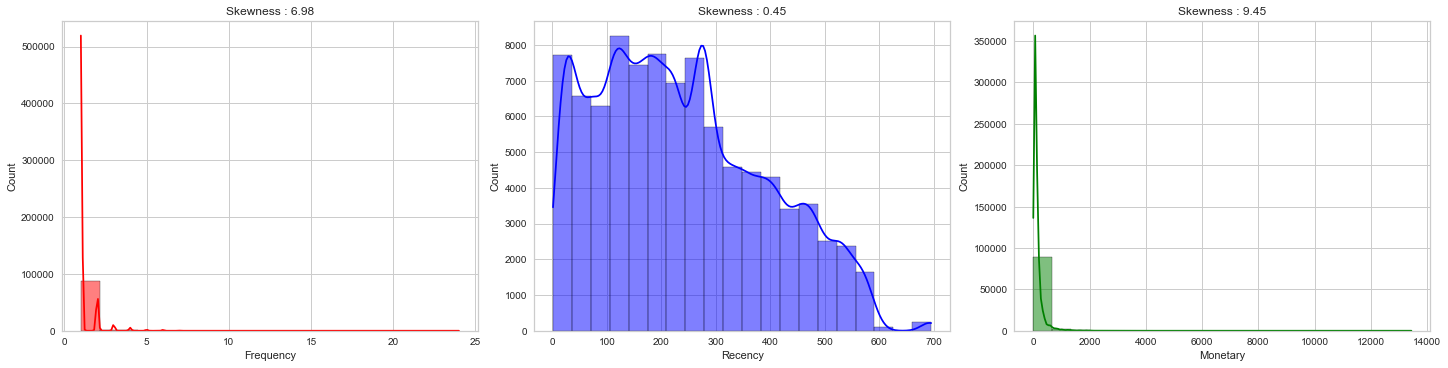

In [25]:
#Visualizing the Recency, Frequency and Monetary distributions.
i = 0
fig = plt.figure(constrained_layout = True,figsize = (20,5))
gs = GridSpec(1, 3, figure=fig)    

col = ['red','blue','green']
for var in list(RFM.columns[1:4]):
    plt.subplot(gs[0,i])
    sns.histplot(RFM[var],color= col[i],kde=True,bins=20)
    plt.title('Skewness ' + ': ' + round(RFM[var].skew(),2).astype(str))
    i= i+1

**Observations**<br>
les données relatives à la fréquence et au pouvoir d'achat sont relativement asymétriques

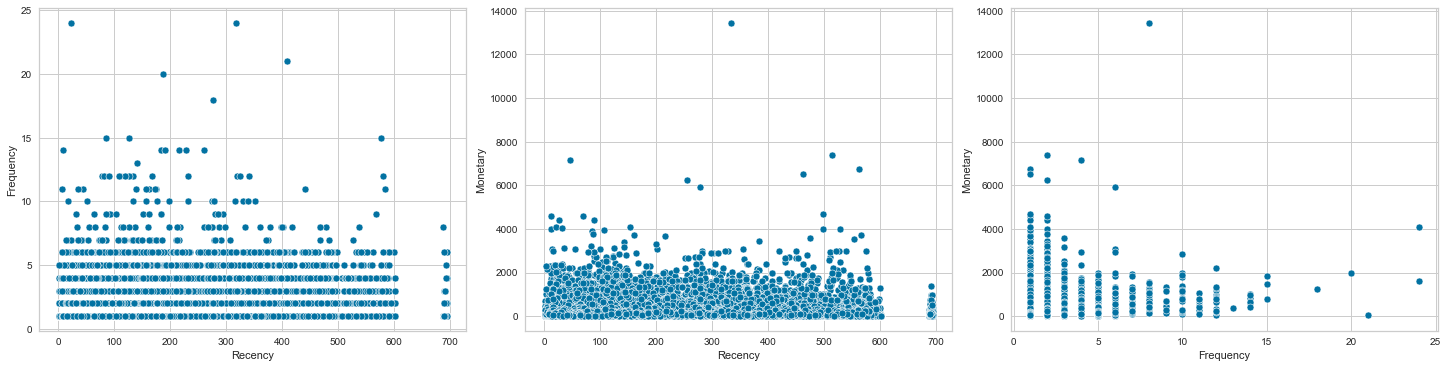

In [26]:


fig = plt.figure(constrained_layout = True,figsize = (20,5))
gs = GridSpec(1, 3, figure=fig) 
#"Recency", "Frequency", "Monetary"
lists=[["Recency", "Frequency"],["Recency","Monetary"],["Frequency","Monetary"]]
i=0

for c in lists:
    
    plt.subplot(gs[0,i])
    sns.scatterplot(data=RFM,x=c[0],y=c[1])    
    i= i+1




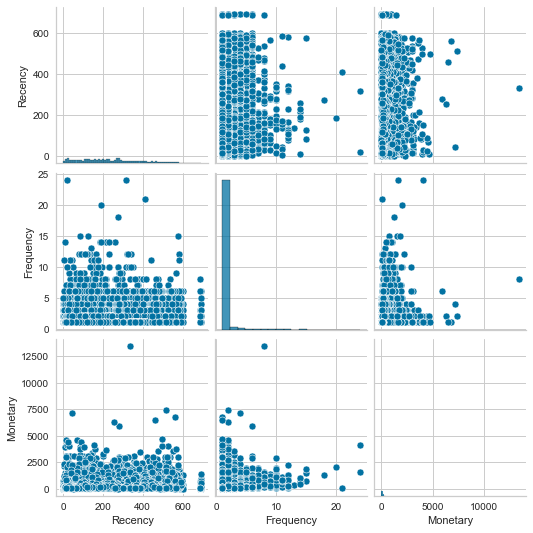

In [27]:
RFM_data = RFM[["Recency", "Frequency", "Monetary"]]

sns.pairplot(RFM_data)

**Observations**<br>

In [28]:
RFM.to_csv('df_rfm',index='False')

In [29]:
RFM.columns

Index(['customer_unique_id', 'Frequency', 'Recency', 'Monetary'], dtype='object')

### 3.Clustering avec kmeans (RFM)

In [30]:
X=RFM[['Frequency', 'Recency', 'Monetary']]
# Scaling input using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Xstd = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


In [34]:
k_rng=range(2, 11)

In [32]:
#fsilhouette(k_rng,Xstd)

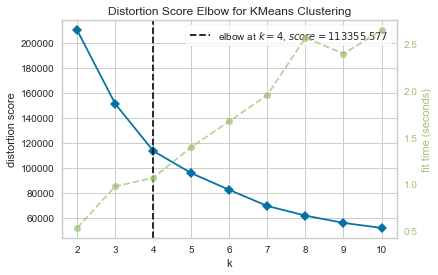

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [36]:
# Instantiate the clustering model and visualizer
model = KMeans(init = 'k-means++', random_state = 42)
visualizer = KElbowVisualizer(model, k=k_rng)

visualizer.fit(Xstd)    # Fit the data to the visualizer
visualizer.poof()

**Remarque**<br>
-le silhouette score est entre - et 1<br>
-score proche de 1==>les points du meme cluster sont très similaire<br>
-score proche de -1==>les points du meme cluster ne sont très similaire


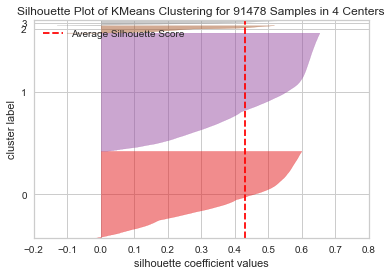

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 91478 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [39]:
#Instantiate the clustering model and visualizer 
#model = KMeans(4)
#visualizer = SilhouetteVisualizer(model)

#visualizer.fit(Xstd)    # Fit the data to the visualizer
#visualizer.poof()

In [42]:
#pour k=4
kmeans = KMeans(n_clusters = 4, init = "k-means++", random_state = 42)
y_kmeans = kmeans.fit_predict(Xstd)
y_kmeans

array([0, 0, 1, ..., 1, 0, 1])

In [43]:
# k_selcted=4
# silhouette_avg = silhouette_score(Xstd, y_kmeans)
# print("For n_clusters =",
#         k_selcted,
#         "The average silhouette_score is :",
#         silhouette_avg,
#     )

For n_clusters = 4 The average silhouette_score is : 0.43179645876872036


For n_clusters = 4 The average silhouette_score is : 0.43179645876872036

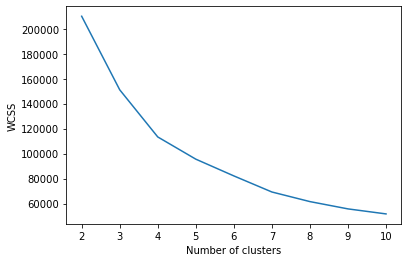

In [33]:

felbow(k_rng,Xstd)

In [ ]:
 ss=silhouette_score(y_kmeans, kmeans.labels_)
 

In [35]:
RFM_km=pd.concat([RFM, pd.Series(y_kmeans)], axis=1)
RFM_km.columns = ['CustomerID', 'Frequency',  'Recency','Monetary', 'ClusterID']
RFM_km

,CustomerID,Frequency,Recency,Monetary,ClusterID
0,0000366f3b9a7992bf8c76cfdf3221e2,1,112,129.90,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,115,18.90,0
2,0000f46a3911fa3c0805444483337064,1,537,69.00,1
3,0000f6ccb0745a6a4b88665a16c9f078,1,321,25.99,1
4,0004aac84e0df4da2b147fca70cf8255,1,288,180.00,1
...,...,...,...,...,...
91473,fffcf5a5ff07b0908bd4e2dbc735a684,2,447,1570.00,2
91474,fffea47cd6d3cc0a88bd621562a9d061,1,262,64.89,1
91475,ffff371b4d645b6ecea244b27531430a,1,568,89.90,1
91476,ffff5962728ec6157033ef9805bacc48,1,119,115.00,0


In [36]:
customer_per_cluster1=fnb_customper_cluster(RFM_km)
customer_per_cluster1

,ClusterID,nb_customers
0,0,49657
1,1,36679
2,2,2053
3,3,3089


In [37]:
RFM_km.describe()

,Frequency,Recency,Monetary,ClusterID
count,91478.000000,91478.000000,91478.000000,91478.000000
mean,1.211712,237.047662,144.949038,0.547148
std,0.679484,152.560470,220.997009,0.703757
min,1.000000,1.000000,0.850000,0.000000
25%,1.000000,114.000000,48.900000,0.000000
50%,1.000000,218.000000,89.900000,0.000000
75%,1.000000,345.000000,159.000000,1.000000
max,24.000000,695.000000,13440.000000,3.000000


**Obserrvations**<br>
le cluster 1 contient le plus de clients
    

<AxesSubplot:title={'center':'Recency'}, xlabel='ClusterID'>

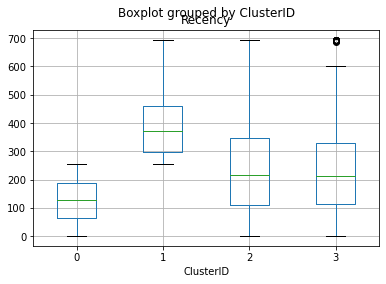

In [38]:

RFM_km.boxplot(column = 'Recency', by = 'ClusterID')

**Observations**<br>
Pour la récence, que le cluster 4 contient des outliers.

<AxesSubplot:title={'center':'Monetary'}, xlabel='ClusterID'>

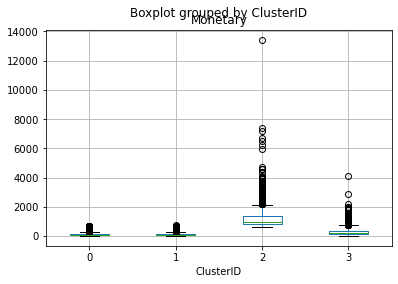

In [39]:
RFM_km.boxplot(column = 'Monetary', by = 'ClusterID')

**Observations**<br>
Pour les montants, 

<AxesSubplot:title={'center':'Frequency'}, xlabel='ClusterID'>

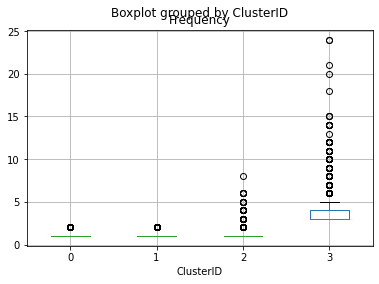

In [40]:
RFM_km.boxplot(column = 'Frequency', by = 'ClusterID')

In [41]:
RFM_km[RFM_km.ClusterID==2]['Frequency'].unique()

array([1, 2, 3, 6, 8, 4, 5], dtype=int64)

**Observations**<br>
-le cluster1 contient que les clienst qui ont achétes peu de fois (1,2)<br>
-le cluster2 contient que les clienst qui ont achétes peu de fois (1,2)<br>
-le cluster3 contient que les clienst qui ont achétes peu de fois (1, 2, 3, 6, 8, 4, 5)<br>
-le cluster4 contient que les clienst qui ont achétes entre 4 et 24 fois <br>

In [42]:
#data=RFM_km[['CustomerID', 'Frequency',  'Recency','Monetary']]
#c1 = RFM_km[RFM_km.ClusterID==0]

#c1=c1[['Frequency', 'Recency', 'Monetary']]
#sns.pairplot(c1)

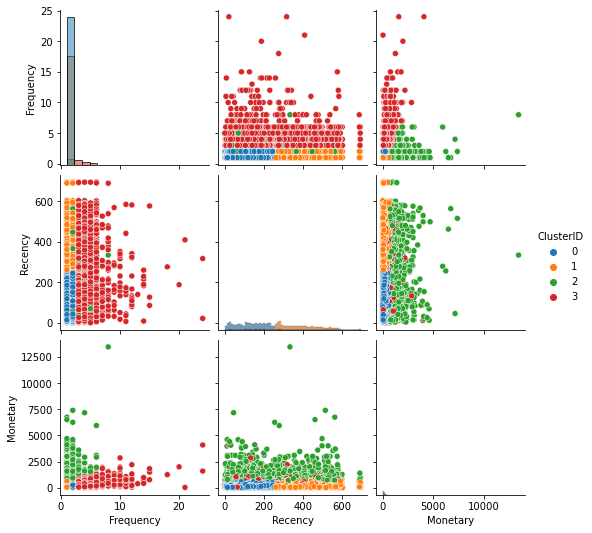

In [43]:
data=RFM_km[['ClusterID', 'Frequency',  'Recency','Monetary']]
sns.pairplot(data,hue='ClusterID', diag_kind="hist",palette=sns.color_palette(n_colors=4))

**Observations**<br>

In [44]:
km_recency_clusters=mean_clus_feat(RFM_km,'ClusterID','Recency')
km_frequency_clusters=mean_clus_feat(RFM_km,'ClusterID','Frequency')
km_monetary_clusters=mean_clus_feat(RFM_km,'ClusterID','Monetary')


In [45]:
km_recency_clusters

,Recency_mean
ClusterID,
0,126.984071
1,386.399029
2,236.316610
3,233.444480


In [46]:
km_frequency_clusters

,Frequency_mean
ClusterID,
0,1.111263
1,1.113525
2,1.263030
3,3.958239


In [47]:
km_monetary_clusters

,Monetary_mean
ClusterID,
0,114.837330
1,115.746640
2,1178.096069
3,289.112522


In [48]:
df = pd.concat([pd.Series([0,1,2,3]),km_recency_clusters, km_frequency_clusters, km_monetary_clusters], axis=1)
df.columns = ["ClusterID", "Recency_mean", "Frequency_mean", "Monetary_mean"]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ClusterID       4 non-null      int64  
 1   Recency_mean    4 non-null      float64
 2   Frequency_mean  4 non-null      float64
 3   Monetary_mean   4 non-null      float64
dtypes: float64(3), int64(1)
memory usage: 256.0 bytes


In [49]:
df

,ClusterID,Recency_mean,Frequency_mean,Monetary_mean
0,0,126.984071,1.111263,114.837330
1,1,386.399029,1.113525,115.746640
2,2,236.316610,1.263030,1178.096069
3,3,233.444480,3.958239,289.112522


**Observations**<br>
-La moyenne de la récence du troisieme cluster est le plus proche de la moyenne de la récence globale(237à peu près). <br>



<AxesSubplot:xlabel='ClusterID', ylabel='Recency_mean'>

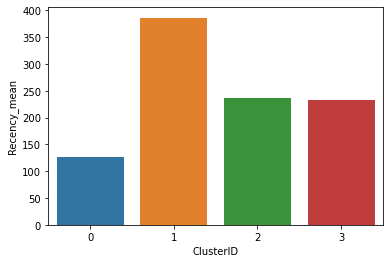

In [50]:
sns.barplot(x=df.ClusterID, y=df.Recency_mean)


**Observations**<br>
Les clients du deuxième cluster sont les clients qui ont les commandes les plus récentes

<AxesSubplot:xlabel='ClusterID', ylabel='Frequency_mean'>

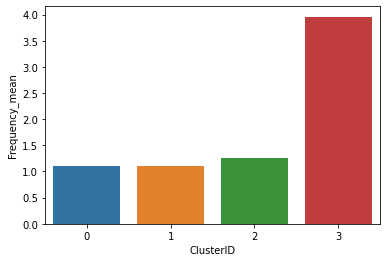

In [51]:
sns.barplot(x=df.ClusterID, y=df.Frequency_mean)


**Observations**<br>
Les clients du cluster 4 sont les clients qui ont effectuées plusieurs commandes

<AxesSubplot:xlabel='ClusterID', ylabel='Monetary_mean'>

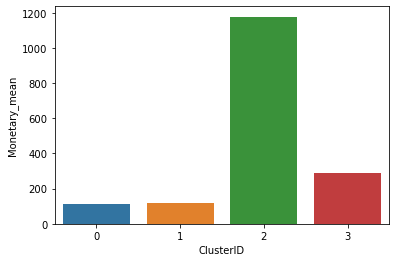

In [52]:
sns.barplot(x=df.ClusterID, y=df.Monetary_mean)

**Observations**<br>
Les clients du 3ème cluster sont les clients qui ont payés le plus.
<br>


**Conclusion**<br>
2.le 1er cluster(cluster 0):clients avec des montants faibles,fréquences faibles et récences faibles<br>
2.le 2ème cluster(cluster 1):clients avec des commandes récentes<br>
2.le 3ème cluster(cluster 2):clients avec des montants élevés.<br>
1.le 4ème cluster(cluster 3): clients avec des montants élevés .<br>


### 4.Clustering avec kmeans (RFM+review_score)

<AxesSubplot:>

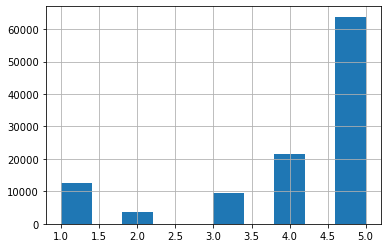

In [53]:
df_cmd['review_score'].hist()

**Observations**<br>
La plupart  desscores sont entre 4.6 et 5 

In [54]:
#scores_review_customers=df_cmd[['customer_unique_id','review_score']]
scores_review_customers=pd.DataFrame(df_cmd.groupby('customer_unique_id')['review_score'].mean())\
.rename(columns={'review_score':'review_score_mean'}).reset_index()
scores_review_customers.head()

,customer_unique_id,review_score_mean
0,0000366f3b9a7992bf8c76cfdf3221e2,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4.0
2,0000f46a3911fa3c0805444483337064,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,4.0
4,0004aac84e0df4da2b147fca70cf8255,5.0


In [55]:
scores_review_customers.shape

(91478, 2)

<AxesSubplot:>

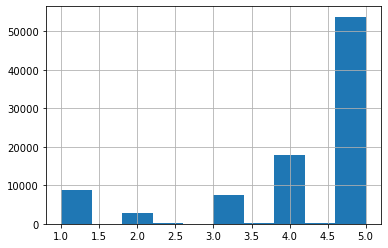

In [56]:
scores_review_customers['review_score_mean'].hist()

In [57]:
RFM.shape

(91478, 4)

In [58]:
RFM_score_review=pd.merge(RFM,scores_review_customers,on='customer_unique_id')
RFM_score_review.head()

,customer_unique_id,Frequency,Recency,Monetary,review_score_mean
0,0000366f3b9a7992bf8c76cfdf3221e2,1,112,129.90,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,115,18.90,4.0
2,0000f46a3911fa3c0805444483337064,1,537,69.00,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,1,321,25.99,4.0
4,0004aac84e0df4da2b147fca70cf8255,1,288,180.00,5.0


In [59]:
RFM_score_review.shape


(91478, 5)

In [60]:
X1=RFM_score_review[['Frequency', 'Recency', 'Monetary','review_score_mean']]
Xstd1 = pd.DataFrame(scaler.fit_transform(X1), columns=X1.columns)

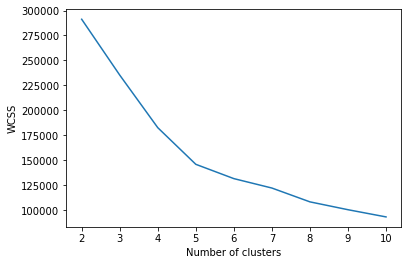

In [61]:
k_rng=range(2, 11)
felbow(k_rng,Xstd1)

In [62]:

kmeans1 = KMeans(n_clusters = 4, init = "k-means++", random_state = 42)
y_kmeans1 = kmeans1.fit_predict(Xstd1)
y_kmeans1

array([2, 2, 0, ..., 0, 2, 0])

In [63]:
RFMS_km=pd.concat([RFM_score_review, pd.Series(y_kmeans1)], axis=1)
RFMS_km.columns = ['CustomerID', 'Frequency',  'Recency','Monetary','review_score_mean', 'ClusterID']
RFMS_km

,CustomerID,Frequency,Recency,Monetary,review_score_mean,ClusterID
0,0000366f3b9a7992bf8c76cfdf3221e2,1,112,129.90,5.0,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,115,18.90,4.0,2
2,0000f46a3911fa3c0805444483337064,1,537,69.00,3.0,0
3,0000f6ccb0745a6a4b88665a16c9f078,1,321,25.99,4.0,0
4,0004aac84e0df4da2b147fca70cf8255,1,288,180.00,5.0,0
...,...,...,...,...,...,...
91473,fffcf5a5ff07b0908bd4e2dbc735a684,2,447,1570.00,5.0,3
91474,fffea47cd6d3cc0a88bd621562a9d061,1,262,64.89,4.0,0
91475,ffff371b4d645b6ecea244b27531430a,1,568,89.90,5.0,0
91476,ffff5962728ec6157033ef9805bacc48,1,119,115.00,5.0,2


In [64]:
cust_per_clust=fnb_customper_cluster(RFMS_km)
cust_per_clust

,ClusterID,nb_customers
0,0,31253
1,1,15383
2,2,41190
3,3,3652


**Observations**<br>
le cluster 3 contient le moins de clients

In [65]:
km1_recency_clusters=mean_clus_feat(RFMS_km,'ClusterID','Recency')
km1_frequency_clusters=mean_clus_feat(RFMS_km,'ClusterID','Frequency')
km1_monetary_clusters=mean_clus_feat(RFMS_km,'ClusterID','Monetary')
km1_score_clusters=mean_clus_feat(RFMS_km,'ClusterID','review_score_mean')

In [66]:
df1 = pd.concat([pd.Series([0,1,2,3,4]),km1_recency_clusters, km1_frequency_clusters, km1_monetary_clusters,km1_score_clusters], axis=1)
df1.columns = ["ClusterID", "Recency_cluster", "Frequency_cluster", "Monetary_cluster","scores_cluster"]
df1

,ClusterID,Recency_cluster,Frequency_cluster,Monetary_cluster,scores_cluster
0,0,392.721851,1.113045,119.874850,4.642178
1,1,229.811675,1.215173,129.269158,1.747210
2,2,121.891187,1.106749,117.806989,4.705434
3,3,234.123494,3.225356,731.703743,3.910513
4,4,NaN,NaN,NaN,NaN


In [67]:
RFMS_km.describe()

,Frequency,Recency,Monetary,review_score_mean,ClusterID
count,91478.000000,91478.000000,91478.000000,91478.000000,91478.000000
mean,1.211712,237.047662,144.949038,4.154631,1.188472
std,0.679484,152.560470,220.997009,1.279228,0.957128
min,1.000000,1.000000,0.850000,1.000000,0.000000
25%,1.000000,114.000000,48.900000,4.000000,0.000000
50%,1.000000,218.000000,89.900000,5.000000,1.000000
75%,1.000000,345.000000,159.000000,5.000000,2.000000
max,24.000000,695.000000,13440.000000,5.000000,3.000000


**Observations**<br>
les scores sont pratiquement identiques dans tous les clusters

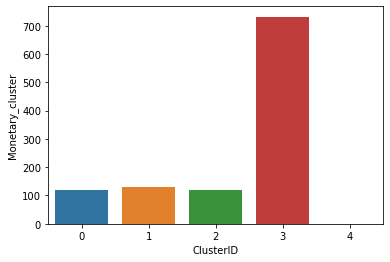

****************************************************************************************************


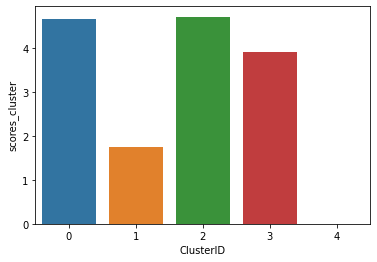

****************************************************************************************************


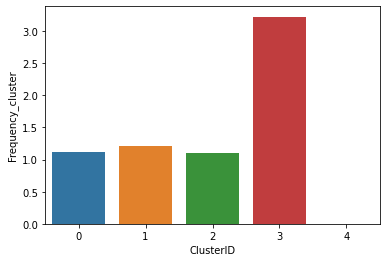

****************************************************************************************************


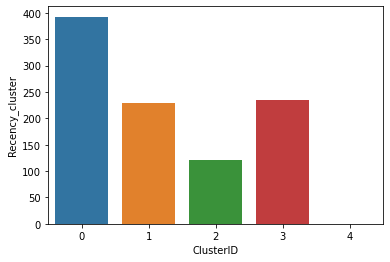

In [68]:
sns.barplot(x=df1.ClusterID, y=df1.Monetary_cluster)
plt.show()
print('*'*100)
sns.barplot(x=df1.ClusterID, y=df1.scores_cluster)
plt.show()
print('*'*100)
sns.barplot(x=df1.ClusterID, y=df1.Frequency_cluster)
plt.show()
print('*'*100)
sns.barplot(x=df1.ClusterID, y=df1.Recency_cluster)
plt.show()

**Observations**<br>
-cluster 0:les clients les plus récents et les plus satisfaits<br>
-cluster1:les clients sont les plus satisfaits<br>
-cluster2:les clients   satisfaistet <br>
-<b>cluster 3:<font color='red'>les clients avec les montants lesplus élevés, achètent fréquement et scores sont bien:poetntiel client</font>

In [69]:
df1.columns

Index(['ClusterID', 'Recency_cluster', 'Frequency_cluster', 'Monetary_cluster',
       'scores_cluster'],
      dtype='object')

### .Clustering avec kmeans (RFM+localisation)

### .Clustering avec kprotype (RFM+localisation)

In [46]:
from kmodes.kprototypes import KPrototypes

In [70]:
df_cmd.columns

Index(['customer_id', 'customer_unique_id', 'customer_city', 'customer_state',
       'order_id', 'order_status', 'order_purchase_timestamp', 'order_item_id',
       'product_id', 'seller_id', 'price', 'payment_type', 'review_id',
       'review_score', 'product_category_name', 'seller_zip_code_prefix',
       'seller_city', 'seller_state'],
      dtype='object')

In [47]:
customer_loc=df_cmd[['customer_unique_id','customer_city', 'customer_state']]
customer_loc['customer_city_state']=customer_loc['customer_city'].str.upper()+customer_loc['customer_state'].str.upper()

C:\Users\IMEN\AppData\Local\Temp\ipykernel_5300\2233972235.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_loc['customer_city_state']=customer_loc['customer_city'].str.upper()+customer_loc['customer_state'].str.upper()


In [72]:
customer_loc=customer_loc

In [50]:
RFM_loc=pd.merge(customer_loc,RFM,on='customer_unique_id')
RFM_loc=RFM_loc[['customer_unique_id','customer_city_state','Frequency','Monetary','Recency']]
RFM_loc

,customer_unique_id,customer_city_state,Frequency,Monetary,Recency
0,861eff4711a542e4b93843c6dd7febb0,FRANCASP,1,124.99,470
1,9eae34bbd3a474ec5d07949ca7de67c0,SANTAREMPA,2,225.98,294
2,9eae34bbd3a474ec5d07949ca7de67c0,SANTAREMPA,2,225.98,294
3,3c799d181c34d51f6d44bbbc563024db,NOVA SANTA RITARS,1,124.99,479
4,23397e992b09769faf5e66f9e171a241,MAGERJ,1,106.99,207
...,...,...,...,...,...
110840,38e482d7770a43f5929378c4dec76d5e,PARNAMIRIMRN,1,1750.00,13
110841,393c2ace23a135d0bcc7e70167448e16,BARREIRASBA,1,145.90,41
110842,5c22dbb9d8b5385953f2f1e6d9d115a7,JORDANIAMG,1,49.90,28
110843,7f5f43a9394964ac51bc5d1e0204ead4,URUACUGO,1,135.98,11


In [63]:
RFM_loc_scal = RFM_loc.copy()

RFM_loc_scal[['Frequency','Monetary','Recency']] = scaler.fit_transform(RFM_loc[['Frequency','Monetary','Recency']])

X_sca=RFM_loc_scal[['Frequency','Monetary','Recency','customer_city_state']]
X_sca

,Frequency,Monetary,Recency,customer_city_state
0,-0.406723,-0.163188,1.531656,FRANCASP
1,0.279454,0.193968,0.375360,SANTAREMPA
2,0.279454,0.193968,0.375360,SANTAREMPA
3,-0.406723,-0.163188,1.590785,NOVA SANTA RITARS
4,-0.406723,-0.226846,-0.196218,MAGERJ
...,...,...,...,...
110840,-0.406723,5.583735,-1.470771,PARNAMIRIMRN
110841,-0.406723,-0.089239,-1.286815,BARREIRASBA
110842,-0.406723,-0.428748,-1.372223,JORDANIAMG
110843,-0.406723,-0.124322,-1.483911,URUACUGO


In [64]:
#Actual clustering
kproto = KPrototypes(n_clusters=4,  init='Huang',n_jobs=-1,n_init=10,verbose=1) 
clusters = kproto.fit(X_sca, categorical=[3])


#Prints the count of each cluster group
pd.Series(clusters).value_counts()

Best run was number 7


KPrototypes(gamma=0.5, init='Huang', n_clusters=4, n_jobs=-1, verbose=1)    1
dtype: int64

In [73]:
k_rng

range(2, 11)

In [ ]:
import time
start = time.time()

felbow_kprototypes(k_rng,X_sca,3)

end = time.time()
elapsed = end - start

print(f'Temps d\'exécution : {elapsed:.2}ms')

2\.cluster start


### .Agglomerative clustering (RFM)

### DBSCAN

In [79]:
df_db=RFM.sample(frac=0.5)
df_db.head()

,customer_unique_id,Frequency,Recency,Monetary
2997,084142ff1817e56910833e3edd9bb3d5,2,261,100.00
90786,fe0617cc03bb1fdefeb9e76e7d316548,1,194,29.99
74143,cf523d0df815451719f36ad96aff8d78,1,217,169.90
78079,da2b78576894a7f95d45bfd20250cc54,3,268,374.15
5866,103d84bb2976d228f12366cdce69da76,1,74,79.90


In [ ]:
!python -V
